<a href="https://colab.research.google.com/github/khmelkoff/TraxRuSummarizer/blob/main/TraxRuSummarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install trax

In [2]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
# from unicodedata import normalize
# import sentencepiece as spm

import trax
from trax import layers as tl
# from trax.fastmath import numpy as jnp

%matplotlib inline

In [3]:
import textwrap
wrapper = textwrap.TextWrapper(width=70)

## Load the data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data = pd.read_csv('/content/drive/MyDrive/lenta-ru-news.csv.zip')
data.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18


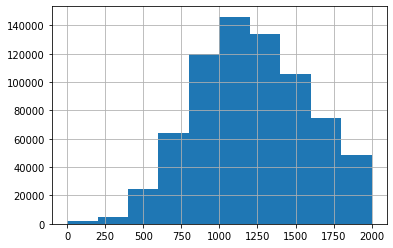

In [6]:
data['text_len'] = [len(x) if not type(x)==float else 0 for x in data.text]
data.text_len[data.text_len < 2000].hist()

In [7]:
# text_full = []  # full text list for train senttence piece tokenizer
text_pairs = [] # paired data for train the model, format: (title, text)
for i in tqdm(range(data.shape[0])):
    if data.iloc[i, 6] >= 200 and data.iloc[i, 6] <= 2000:
        # text_full.append(data.iloc[i, 1].lower() + '\n' + data.iloc[i, 2].lower())
        # list of (article, summary)
        text_pairs.append((data.iloc[i, 2].lower(), data.iloc[i, 1].lower()))

# save full text to text file        
# with open('full_text.txt', 'w', encoding='utf-8') as file:
#     file.write('\n'.join(text_full))  

100%|██████████| 800975/800975 [01:03<00:00, 12705.50it/s]


In [8]:
text_pairs[0]

('бои у сопоцкина и друскеник закончились отступлением германцев. неприятель, приблизившись с севера к осовцу начал артиллерийскую борьбу с крепостью. в артиллерийском бою принимают участие тяжелые калибры. с раннего утра 14 сентября огонь достиг значительного напряжения. попытка германской пехоты пробиться ближе к крепости отражена. в галиции мы заняли дембицу. большая колонна, отступавшая по шоссе от перемышля к саноку, обстреливалась с высот нашей батареей и бежала, бросив парки, обоз и автомобили. вылазки гарнизона перемышля остаются безуспешными. при продолжающемся отступлении австрийцев обнаруживается полное перемешивание их частей, захватываются новые партии пленных, орудия и прочая материальная часть. на перевале ужок мы разбили неприятельский отряд, взяли его артиллерию и много пленных и, продолжая преследовать, вступили в пределы венгрии. \n«русский инвалид», 16 сентября 1914 года.',
 '1914. русские войска вступили в\xa0пределы венгрии  ')

## Load / Train BPE tokenizer

In [ ]:
# train tokenizer
# spm.SentencePieceTrainer.train('--input=full_text.txt --pad_id=0 --bos_id=-1 --eos_id=1 --unk_id=2 \
#                                --model_prefix=bpe --vocab_size=32000 --model_type=bpe')
# sp = spm.SentencePieceProcessor()
# sp.load('/content/drive/MyDrive/bpe.model')

In [9]:
s0 = text_pairs[10][0]
text_list = wrapper.wrap(s0[:300])
for line in text_list:
    print(line)

сегодня областной центр сахалина и курил получил статус очага
распространения холеры. как сообщает итар-тасс со ссылкой на пресс-
центр администрации сахалинской области, в лечебных учреждениях южно-
сахалинска уже находятсятся 5 горожан, причем у двоих из них болезнь
проходит в средне-тяжелой форме.


In [ ]:
# # tokenizer check
# print('encode: text => id:')
# print(sp.encode_as_pieces(s0[:300]))
# print('')
# print(sp.encode_as_ids(s0[:300]))
# print('')
# print('decode: id => text:')
# print(sp.decode_pieces(sp.encode_as_pieces(s0[:300])))
# print('')
# print(f'Beginning of sentence id: {sp.bos_id()}')
# print(f'Pad id: {sp.pad_id()}')
# print(f'End of sentence id: {sp.eos_id()}')
# print(f'Unknown id: {sp.unk_id()}')
# print(f'Vocab size: {sp.vocab_size()}')      

In [ ]:
# uid = 18298
# spiece = "\u2581Саха"
# unknown = "_НЕИЗВЕСТНОСТЬ_"

# # id <=> piece conversion
# print(f'SentencePiece for ID {uid}: {sp.id_to_piece(uid)}')
# print(f'ID for Sentence Piece {spiece}: {sp.piece_to_id(spiece)}')

# # returns 0 for unknown tokens (we can change the id for UNK)
# print(f'ID for unknown text {unknown}: {sp.piece_to_id(unknown)}')

In [ ]:
# # vocab's head and tail test
# print('\nId\tSentP\tControl?')
# print('------------------------')
# for uid in range(7):
#     print(uid, sp.id_to_piece(uid), sp.is_control(uid), sep='\t')
    
# for uid in range(sp.vocab_size()-7,sp.vocab_size()):
#     print(uid, sp.id_to_piece(uid), sp.is_control(uid), sep='\t')

## Data: preprocess and create generators

In [10]:
# inintial shuffling
random.shuffle(text_pairs)
margin = int(len(text_pairs)*0.95)
train_text_pairs = text_pairs[:margin]
print('train cases: ', len(train_text_pairs))
eval_text_pairs = text_pairs[margin:]
print('eval cases: ', len(eval_text_pairs))

train cases:  686277
eval cases:  36120


In [11]:
def data_generator(data, shuffle=True):
    '''
      Input: 
        data - list containing tuples (article, summary)
        shuffle - If True: shuffle the data order
      Output:
        a tuple containing 2 elements:
        article
        summary
    '''
    
    data_lng = len(data) # len(data)
    index_list = [*range(data_lng)] # Create a list with the ordered indexes of sample data
    
    index = 0 # Start with the first element
    while True:
        # Wrap the index each time that we reach the end of the list
        if index >= data_lng:
            index = 0
            if shuffle:
                random.shuffle(index_list) # re-shuffle the order
            
        sample = data[index_list[index]]
        index += 1
        yield(sample)

# create data streams
def train_data_stream():
    return data_generator(train_text_pairs, shuffle=True)

def eval_data_stream():
    return data_generator(eval_text_pairs, shuffle=True)        

In [12]:
PAD, EOS, UNK = 0, 1, 2

def detokenize(integers):
    s = trax.data.detokenize(
        integers,
        vocab_type='sentencepiece',
        vocab_file='bpe.model',
        vocab_dir='/content/drive/MyDrive/')
    return wrapper.fill(s)


def tokenize(s):
    inputs =  next(trax.data.tokenize(
        iter([s]),
        vocab_type='sentencepiece',
        vocab_file='bpe.model',
        vocab_dir='/content/drive/MyDrive/'))
    
    return list(inputs) + [EOS]
 
    
vocab_size = trax.data.vocab_size(
    vocab_type='sentencepiece',
    vocab_file='bpe.model',
    vocab_dir='/content/drive/MyDrive/')

print('vocab size: ', vocab_size)

vocab size:  16000


In [13]:
tokenize('тест')

[15117, 1]

In [14]:
tokenize('НЕИЗВЕСТНОСТЬ')

[15924, 2, 1]

In [15]:
tokenized = tokenize('сведения о пассажирах на всех видах транспорта, где используются именные проездные билеты')
print('tokenized:')
print(tokenized)
print('len=', len(tokenized))
detokenized = detokenize(tokenized)
print('detokenized:')
print(detokenized)
print('len=', len(detokenized.split()))

tokenized:
[3044, 11, 1627, 1080, 25, 1445, 288, 4205, 5442, 15945, 939, 11463, 1410, 164, 13393, 164, 8476, 1]
len= 18
detokenized:
сведения о пассажирах на всех видах транспорта, где используются
именные проездные билеты
len= 12


In [16]:
# Concatenate tokenized inputs and targets using 0 as separator.
def preprocess(stream):
    for (article, summary) in stream:
        joint = np.array(list(article) + [EOS, PAD] + list(summary) + [EOS])
        mask = [0] * (len(list(article)) + 2) + [1] * (len(list(summary)) + 1) 
        yield joint, joint, np.array(mask)

# You can combine a few data preprocessing steps into a pipeline like this.
input_pipeline = trax.data.Serial(
    # Tokenizes
    trax.data.Tokenize(vocab_type='sentencepiece',
                       vocab_dir='/content/drive/MyDrive/',
                       vocab_file='bpe.model'),
    # Uses function defined above
    preprocess,
)

# Apply preprocessing to data streams.
train_stream = input_pipeline(train_data_stream())
eval_stream = input_pipeline(eval_data_stream())

In [17]:
train_input, train_target, train_mask = next(train_stream)
# assert sum((train_input - train_target)**2) == 0  # They are the same in Language Model (LM).

In [18]:
# check pad (id:0) and sep/eos (id:1)
print(train_input[-20:])

[ 6062    56   107  4229 15983 15962  1401 15949     1     0  1025 13896
  3019  4848  1515    78  8788     5 12703     1]


## Batching and Bucketing 

In [19]:
# batch of 8 sentences of length < 256 , 4 of length < 512....
boundaries =  [256, 512, 1024]
batch_sizes = [16, 8, 4, 2]

# Create the streams.
train_batch_stream = trax.data.BucketByLength(
    boundaries, batch_sizes)(train_stream)

eval_batch_stream = trax.data.BucketByLength(
    boundaries, batch_sizes)(eval_stream)

In [20]:
input_batch, _, mask_batch = next(train_batch_stream)

# Shape of the input_batch
input_batch.shape

(8, 512)

In [21]:
# check autopadding endig of sample
# 1, 0, <not 0 digit>... - end of article and start of summary
input_batch[0]

array([ 6411,  2046,     5,  3603, 14037,  1072,    11,  4350,   730,
          25,   154,  2223,   106,  3421,  4363,    75,  3190,   890,
         701, 15945,  2049,   586, 11492, 12894,  1797,  1111, 15945,
         258,    81,  1234,   295,   586,  4075,  6993,   309,  3197,
        3233,     5,   421,   191,  6311,   462,  2066,  5031, 15949,
        1002,    26,    25,  5026,  2046,   657,  1325,    10,    81,
        3737, 11650,   580,  1110, 15957,   245,  3072,   653, 15945,
        5425,   193,   249,  4835, 10278,    16,  5069,    17,    81,
         103,  2223,   768,  2431,   295,  5355,  7519, 12894,   890,
        1446,    17,   199,  8654,  2044,    16,  9284,   237,  3197,
        3233,     5,   421,   191,  6311,   462,  2066,  5031, 15949,
         505, 15504,   907,  7047,   794,  1324, 12291, 15949,  6223,
        4654, 13090,  7978,    64,  2676,   768, 15341, 10188, 15949,
        6411, 15945,     5,  1140,  2162, 15945,  9576, 11538,  5823,
          75,   890,

## Transformer Model

### Positional encoder

In [22]:
def PositionalEncoder(vocab_size, d_model, dropout, max_len, mode):
    """Returns a list of layers that: 
    1. takes a block of text as input, 
    2. embeds the words in that text, and 
    3. adds positional encoding, 
       i.e. associates a number in range(max_len) with 
       each word in each sentence of embedded input text 
    
    The input is a list of tokenized blocks of text
    
    Args:
        vocab_size (int): vocab size.
        d_model (int):  depth of embedding.
        dropout (float): dropout rate (how much to drop out).
        max_len (int): maximum symbol length for positional encoding.
        mode (str): 'train' or 'eval'.
    """
    # Embedding inputs and positional encoder
    return [ 
        # Add embedding layer of dimension (vocab_size, d_model)
        tl.Embedding(vocab_size, d_model),  
        # Use dropout with rate and mode specified
        tl.Dropout(rate=dropout, mode=mode), 
        # Add positional encoding layer with maximum input length and mode specified
        tl.PositionalEncoding(max_len=max_len, mode=mode)] 

### Feed-Forward layer

In [23]:
def FeedForward(d_model, d_ff, dropout, mode, ff_activation):
    """Returns a list of layers that implements a feed-forward block.

    The input is an activation tensor.

    Args:
        d_model (int):  depth of embedding.
        d_ff (int): depth of feed-forward layer.
        dropout (float): dropout rate (how much to drop out).
        mode (str): 'train' or 'eval'.
        ff_activation (function): the non-linearity in feed-forward layer.

    Returns:
        list: list of trax.layers.combinators.Serial that maps an activation tensor to an activation tensor.
    """
    
    # Feed-forward block (list) with two dense layers with dropout and input normalized
    return [ 
        # Normalize layer inputs
        tl.LayerNorm(), 
        # Add first feed forward (dense) layer
        tl.Dense(d_ff), 
        # Add activation function passed in as a parameter
        ff_activation(),  # ReLU
        # Add dropout with rate and mode specified (don't use dropout during evaluation)
        tl.Dropout(rate=dropout, mode=mode), 
        # Add second feed forward layer
        tl.Dense(d_model), 
        # Add dropout with rate and mode specified
        tl.Dropout(rate=dropout, mode=mode) 
    ]

### Decoder Block

In [24]:
def DecoderBlock(d_model, d_ff, n_heads,
                 dropout, mode, ff_activation):
    """Returns a list of layers that implements a Transformer decoder block.

    The input is an activation tensor.

    Args:
        d_model (int):  depth of embedding.
        d_ff (int): depth of feed-forward layer.
        n_heads (int): number of attention heads.
        dropout (float): dropout rate (how much to drop out).
        mode (str): 'train' or 'eval'.
        ff_activation (function): the non-linearity in feed-forward layer.

    Returns:
        list: list of trax.layers.combinators.Serial that maps an activation tensor to an activation tensor.
    """
        
    # List of two Residual blocks: the attention with normalization and dropout and feed-forward blocks
    return [
      tl.Residual(
          # Normalize layer input
          tl.LayerNorm(), 
          # Add causal attention 
          tl.CausalAttention(d_model, n_heads=n_heads, dropout=dropout, mode=mode) 
        ),
      tl.Residual(
          # Add feed-forward block
          # The feed-forward block takes care of normalization
          FeedForward(d_model, d_ff, dropout, mode, ff_activation)
        ),
      ]

### Trnsformer (decoder)

In [25]:
def SumTransformer(vocab_size=vocab_size,
                  d_model=512,
                  d_ff=2048,
                  n_layers=8,
                  n_heads=8,
                  dropout=0.1,
                  max_len=4096,
                  mode='train',
                  ff_activation=tl.Relu):
    """Returns a Transformer language model.

    The input to the model is a tensor of tokens. (This model uses only the
    decoder part of the overall Transformer.)

    Args:
        vocab_size (int): vocab size.
        d_model (int):  depth of embedding.
        d_ff (int): depth of feed-forward layer.
        n_layers (int): number of decoder layers.
        n_heads (int): number of attention heads.
        dropout (float): dropout rate (how much to drop out).
        max_len (int): maximum symbol length for positional encoding.
        mode (str): 'train', 'eval' or 'predict', predict mode is for fast inference.
        ff_activation (function): the non-linearity in feed-forward layer.

    Returns:
        trax.layers.combinators.Serial: A Transformer language model as a layer that maps from a tensor of tokens
        to activations over a vocab set.
    """
    
    # Stack of decoder blocks with n_layers with necessary parameters
    decoder_blocks = [ 
        DecoderBlock(d_model, d_ff, n_heads, dropout, mode, ff_activation) for _ in range(n_layers)] 

    # The complete model
    return tl.Serial(
        # Use teacher forcing (feed output of previous step to current step)
        tl.ShiftRight(mode=mode), 
        # Add embedding inputs and positional encoder
        PositionalEncoder(vocab_size, d_model, dropout, max_len, mode),
        # Add decoder blocks
        decoder_blocks, 
        # Normalize layer
        tl.LayerNorm(), 

        # Add dense layer of vocab_size (since need to select a word to translate to)
        # (a.k.a., logits layer. Note: activation already set by ff_activation)
        tl.Dense(vocab_size), 
        # Get probabilities with Logsoftmax
        tl.LogSoftmax() 
    )

In [26]:
print(SumTransformer(n_layers=1))

Serial[
  Serial[
    ShiftRight(1)
  ]
  Embedding_16000_512
  Dropout
  PositionalEncoding
  Serial[
    Branch_out2[
      None
      Serial[
        LayerNorm
        Serial[
          Serial[
            Serial[
              Branch_out3[
                [Dense_512, Serial[
                  SplitIntoHeads
                ]]
                [Dense_512, Serial[
                  SplitIntoHeads
                ]]
                [Dense_512, Serial[
                  SplitIntoHeads
                ]]
              ]
              DotProductCausalAttention_in3
              Serial[
                MergeHeads
              ]
              Dense_512
            ]
          ]
        ]
      ]
    ]
    Add_in2
  ]
  Serial[
    Branch_out2[
      None
      Serial[
        LayerNorm
        Dense_2048
        Serial[
          Relu
        ]
        Dropout
        Dense_512
        Dropout
      ]
    ]
    Add_in2
  ]
  LayerNorm
  Dense_16000
  LogSoftmax
]


## Training

In [27]:
from trax.supervised import training

def training_loop(SumTransformer, train_gen, eval_gen, output_dir = "~/model"):
    '''
    Input:
        SumTransformer (trax.layers.combinators.Serial): The transformer model.
        train_gen (generator): Training stream of data.
        eval_gen (generator): Evaluation stream of data.
        output_dir (str): folder to save your file.
        
    Returns:
        trax.supervised.training.Loop: Training loop.
    '''
    output_dir = os.path.expanduser(output_dir)  # trainer is an object
    # for initial train
    # lr_schedule = trax.lr.warmup_and_rsqrt_decay(n_warmup_steps=4000, max_value=0.00025)
    # for re-train
    lr_schedule = trax.supervised.lr_schedules.constant(0.0001)

    train_task = training.TrainTask( 
      labeled_data=train_gen, # The training generator
      loss_layer=tl.CrossEntropyLoss(), # Loss function 
      optimizer=trax.optimizers.Adam(0.0001), # Optimizer 
      lr_schedule=lr_schedule,
      n_steps_per_checkpoint=100
    )

    eval_task = training.EvalTask( 
      labeled_data=eval_gen, 
      metrics=[tl.CrossEntropyLoss(), tl.Accuracy()] 
    )

    loop = training.Loop(SumTransformer(d_model=512,
                                       d_ff=2048,
                                       n_layers=8,
                                       n_heads=8,
                                       mode='train'),
                         train_task,
                         eval_tasks=[eval_task],
                         output_dir=output_dir)
    
    return loop

In [28]:
# sync the train dir with Google Drive dir
!rsync -a /content/drive/MyDrive/model2/ ~/

In [ ]:
# Should take around 1 minute per 100 step on GPU
# !rm -f ~/model/model.pkl.gz
loop = training_loop(SumTransformer, train_batch_stream, eval_batch_stream)
loop.run(40000)


Step  40100: Ran 100 train steps in 106.61 secs
Step  40100: train CrossEntropyLoss |  5.99441719
Step  40100: eval  CrossEntropyLoss |  5.75384235
Step  40100: eval          Accuracy |  0.16417910

Step  40200: Ran 100 train steps in 78.38 secs
Step  40200: train CrossEntropyLoss |  5.97902918
Step  40200: eval  CrossEntropyLoss |  5.87748003
Step  40200: eval          Accuracy |  0.13333334

Step  40300: Ran 100 train steps in 57.37 secs
Step  40300: train CrossEntropyLoss |  5.87072420
Step  40300: eval  CrossEntropyLoss |  5.79720879
Step  40300: eval          Accuracy |  0.18584071

Step  40400: Ran 100 train steps in 56.85 secs
Step  40400: train CrossEntropyLoss |  5.87892008
Step  40400: eval  CrossEntropyLoss |  5.76516867
Step  40400: eval          Accuracy |  0.19431281

Step  40500: Ran 100 train steps in 57.58 secs
Step  40500: train CrossEntropyLoss |  5.80265379
Step  40500: eval  CrossEntropyLoss |  5.93631124
Step  40500: eval          Accuracy |  0.13178295

Step  40

In [1]:
# copy the model to Google Drive
!cp ~/model/model.pkl.gz /content/drive/MyDrive/model/

cp: cannot stat '/root/model/model.pkl.gz': No such file or directory


In [ ]:
# sync Google Drive dir with the train dir
!rsync -a ~/model /content/drive/MyDrive/model2/

## Evaluate

### Predict next symbol (greedy)

In [34]:
# Get the model architecture
model = SumTransformer(mode='eval')

# Load the pre-trained weights
model.init_from_file('/root/model/model.pkl.gz', weights_only=True)

In [47]:
def next_symbol(cur_output_tokens, model):
    """Returns the next symbol for a given sentence.

    Args:
        cur_output_tokens (list): tokenized sentence with EOS and PAD tokens at the end.
        model (trax.layers.combinators.Serial): The transformer model.

    Returns:
        int: tokenized symbol.
    """

    # current output tokens length
    token_length = len(cur_output_tokens)
    # calculate the minimum power of 2 big enough to store token_length
    padded_length = 2**int(np.ceil(np.log2(token_length + 1)))

    # Fill cur_output_tokens with 0's until it reaches padded_length
    padded = list(cur_output_tokens) + [0] * (padded_length - token_length)
    padded_with_batch = np.array(padded)[None, :] # setting the batch dim

    # model expects a tuple containing two padded tensors (with batch)
    output, _ = model((padded_with_batch, padded_with_batch)) 
    # To get log_probs you need to index output with 0 in the first dim
    # token_length in the second dim and all of the entries for the last dim.
    log_probs = output[0, token_length, :]
    
    return int(np.argmax(log_probs))

In [41]:
train_text_pairs[0]

('подразделения мчс россии завершили ликвидацию последствий пожаров в населенных пунктах хакасии, сообщает в четверг, 23 апреля, риа новости со ссылкой на республиканское управление ведомства. «мчс россии начинает поэтапный вывод группировки сил, привлеченных в хакасию для оказания помощи населению при разборе завалов и сгоревших конструкций», — говорится в сообщении главного управления мчс по республике хакасия. первая группа спасателей из 120 человек улетает ведомственным самолетом. на борт загружен аварийно-спасательный инструмент. до конца недели все подразделения мчс россии из других регионов покинут хакасию и вернутся к местам постоянной дислокации. 12 апреля лесные пожары, распространявшиеся на территории хакасии, перекинулись на населенные пункты. пострадало более 40 населенных пунктов, около 5 тысяч человек остались без жилья. уже 15 апреля в мчс сообщили о ликвидации всех пожаров в населенных пунктах хакасии, красноярского края и забайкалья. по последним данным, от пожаров по

In [48]:
sentence_test_nxt_symbl = "подразделения мчс россии завершили ликвидацию последствий пожаров в населенных пунктах хакасии, сообщает в четверг, 23 апреля, риа новости."
detokenize([next_symbol(tokenize(sentence_test_nxt_symbl)+[0], model)])

32
26
[ 5317  3090   278  2130    18 14638   408  9828 12479     5  9291 15468
   710    26  7054 15945   258     5  1801 15945  1628  1215 15945   785
  1006 15949]


'в'

### Greedy decode

In [51]:
def greedy_decode(input_sentence, model):
    """Greedy decode function.

    Args:
        input_sentence (string): a sentence or article.
        model (trax.layers.combinators.Serial): Transformer model.

    Returns:
        string: summary of the input.
    """
    
    cur_output_tokens = tokenize(input_sentence) + [0]
    generated_output = [] 
    cur_output = 0 
    EOS = 1 
    
    while cur_output != EOS:
        # Get next symbol
        cur_output = next_symbol(cur_output_tokens, model)
        # Append next symbol to original sentence
        cur_output_tokens.append(cur_output)
        # Append next symbol to generated sentence
        generated_output.append(cur_output)

        if len(generated_output) >= 20:
            print(detokenize(generated_output))
            break

        print(detokenize(generated_output))
    
    return detokenize(generated_output)

In [52]:
test_sentence = "подразделения мчс россии завершили ликвидацию последствий пожаров в населенных пунктах хакасии, сообщает в четверг, 23 апреля, риа новости."
print(wrapper.fill(test_sentence), '\n')
print(greedy_decode(test_sentence, model))

подразделения мчс россии завершили ликвидацию последствий пожаров в
населенных пунктах хакасии, сообщает в четверг, 23 апреля, риа
новости. 

32
26
[ 5317  3090   278  2130    18 14638   408  9828 12479     5  9291 15468
   710    26  7054 15945   258     5  1801 15945  1628  1215 15945   785
  1006 15949]
в
32
27
[5317, 3090, 278, 2130, 18, 14638, 408, 9828, 12479, 5, 9291, 15468, 710, 26, 7054, 15945, 258, 5, 1801, 15945, 1628, 1215, 15945, 785, 1006, 15949, 5]
в результате
32
28
[5317, 3090, 278, 2130, 18, 14638, 408, 9828, 12479, 5, 9291, 15468, 710, 26, 7054, 15945, 258, 5, 1801, 15945, 1628, 1215, 15945, 785, 1006, 15949, 5, 818]
в результате результате
32
29
[5317, 3090, 278, 2130, 18, 14638, 408, 9828, 12479, 5, 9291, 15468, 710, 26, 7054, 15945, 258, 5, 1801, 15945, 1628, 1215, 15945, 785, 1006, 15949, 5, 818, 818]
в результате результате результате
32
30
[5317, 3090, 278, 2130, 18, 14638, 408, 9828, 12479, 5, 9291, 15468, 710, 26, 7054, 15945, 258, 5, 1801, 15945, 1628, 1215,

KeyboardInterrupt: ignored

In [ ]:
from trax.supervised import decoding

In [ ]:
test_inputs = tokenize(inputs) 

In [ ]:
# Temperature is a parameter for sampling.
#   # * 0.0: same as argmax, always pick the most probable token
#   # * 1.0: sampling from the distribution (can sometimes say random things)
#   # * values inbetween can trade off diversity and quality, try it out!
output = decoding.autoregressive_sample(model, inputs=np.array(test_inputs)[None, :],
                                        temperature=0.0, max_length=5) # originally max_length=10
print(wrapper.fill(pretty_decode(output[0])))